In [1]:
#conexão com o google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Configuração do ambiente

In [2]:
!apt install libomp-dev
!pip install faiss-gpu --upgrade
!pip install git+https://github.com/pedrogengo/pygaggle.git --upgrade
!wget -c https://www.dropbox.com/s/m1n2wf80l1lb9j1/collection.tar.gz?dl=1 -O - | tar -xz
!wget https://raw.githubusercontent.com/castorini/anserini/master/src/main/resources/topics-and-qrels/qrels.dl20-passage.txt
!wget https://raw.githubusercontent.com/castorini/anserini/master/src/main/resources/topics-and-qrels/topics.dl20.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 0s (2,952 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.

In [3]:
import argparse
import collections
import torch
import json
import numpy as np
import pygaggle
import time
import pandas as pd
import os
import subprocess
import platform
import re
import seaborn as sns
import matplotlib.pyplot as plt

from pyserini.search import get_qrels_file
from pyserini.util import download_evaluation_script
from collections import OrderedDict
from pygaggle.rerank.base import Query, Text
from pygaggle.rerank.transformer import DuoT5
from itertools import islice
from transformers import T5ForConditionalGeneration
from tqdm import tqdm
from typing import List

2021-12-08 02:44:45 [INFO] loader: Loading faiss with AVX2 support.
2021-12-08 02:44:45 [INFO] loader: Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2021-12-08 02:44:45 [INFO] loader: Loading faiss.
2021-12-08 02:44:45 [INFO] loader: Successfully loaded faiss.


## Classe para teste de novas funções de agregação

In [4]:
class duoT5Aggregation():
    
    def __init__(self):
        self.paper_results = self.__create_paper_results()
        self.output_pattern_name = lambda num_rerank: f'./pointwise_scores.duo.{num_rerank}.trec'
    
    def __create_paper_results(self):
        '''
        Returns a Dataframe containing the results presented in the paper
        Expando-Mono-Duo for different rerank documents sizes.
        '''
        cols = ['qtd_docs', 'MAP', 'MRR', 'P@20', 
                'P@30', 'R@100', 'R@1000',
                'NDCG@10', 'NDCG@20', 'J@10',
                'J@20', 'aggregation']
        
        rows = [
            [30, 0.4311, 0.8596, 0.4389, 0.3444, 0.5777, 0.5777, 0.7308, 0.7028, 0.9852, 0.913, 'sym_sum'],
            [50, 0.512, 0.8617, np.nan, np.nan, np.nan, 0.8699, 0.7306, np.nan, np.nan, np.nan, 'sym_sum'],
            [300, 0.5111, 0.8613, 0.4343, 0.3617, 0.7837, 0.8166, 0.7293, 0.6996, 0.9796, 0.913, 'sym_sum']
        ]
        
        return pd.DataFrame(rows, columns = cols)
    
    def pointwise_scores_to_trec(self, agg_output_path, pointwise_scores):
        '''
        Creates TREC file with the rerank scores.
        Params:
            agg_output_path (string): path for the new file
            pointwise_scores (dict): ordered dictionary with scores for each document per query
        '''
        with open(agg_output_path, 'w') as fout:
            for query_id in pointwise_scores:
                for rank, doc in enumerate(pointwise_scores[query_id], start=1): 
                    fout.write(f"{query_id} Q0 {doc} {rank} {pointwise_scores[query_id][doc]} duo\n")
    
    def test_single_aggregate_function(self, num_rerank, agg_func, name, pairwise_scores, **kwargs):
        pointwise_scores = agg_func(pairwise_scores=pairwise_scores, **kwargs)
        ordered_pointwise = self.create_ordered_pointwise_scores(pointwise_scores)
        self.pointwise_scores_to_trec(self.output_pattern_name(num_rerank), ordered_pointwise)
        df_result = self._get_results(num_rerank, name)
        df_judge = self.get_judge(self.output_pattern_name(num_rerank))
        df_result = pd.concat((df_result, df_judge), axis=1)
        return df_result
    
    def test_aggregate_function(self, agg_func, name, **kwargs):
        df_output = None
        for i in [30, 50, 100, 300]:
            pairwise_scores = self.open_pairwise_scores(i)
            df_result = self.test_single_aggregate_function(i, agg_func, name, pairwise_scores, **kwargs)
            if type(df_output) == type(None):
                df_output = df_result.copy()
            else:
                df_output = pd.concat((df_output, df_result), axis=0)
        return df_output
    
    def _get_results(self, num_rerank, function):
        script_path = download_evaluation_script('trec_eval')
        cmd_prefix = ['java', '-jar', script_path]
        args = f'-c -l 2 -m ndcg_cut.10,20 -m map -m P.20,30 -m recall.100,1000 -m recip_rank ./qrels.dl20-passage.txt {self.output_pattern_name(num_rerank)}'.split()
        if len(args) > 1:
            cmd = cmd_prefix + args[:]
            if not os.path.exists(cmd[-2]):
                cmd[-2] = get_qrels_file(cmd[-2])
        else:
            cmd = cmd_prefix
        shell = platform.system() == "Windows"
        process = subprocess.Popen(cmd,
                                stdout=subprocess.PIPE,
                                stderr=subprocess.PIPE,
                                shell=shell)
        stdout, stderr = process.communicate()
        if stderr:
            print(stderr.decode("utf-8"))
        cols = ['qtd_docs', 'MAP', 'MRR', 'P@20', 
                'P@30', 'R@100', 'R@1000',
                'NDCG@10', 'NDCG@20', 'function']
        return pd.DataFrame([[num_rerank] + re.sub(r'.*\s+\tall\t', '', stdout.decode("utf-8")).split('\n')[:-1] + [function]], columns = cols)
    
    def create_ordered_pointwise_scores(self, pointwise_scores):
        ordered_pointwise = dict()
        for query_id in pointwise_scores:
            ordered_pointwise[query_id] = OrderedDict(sorted(pointwise_scores[query_id].items(), key=lambda x: float(x[1]), reverse=True))
        return ordered_pointwise
    
    def open_pairwise_scores(self, num_rerank):
      f = open(f'./drive/MyDrive/Projeto Final/ia376e_projeto_final/results/output_duot5_pairwise_scores_{num_rerank}.json',)
      pairwise_scores = json.load(f)
      return pairwise_scores

    def load_qrels(self, path):
      """Loads qrels into a dict of key: query_id, value: set of relevant doc ids."""
      qrels = collections.defaultdict(set)
      with open(path) as f:
          for i, line in enumerate(f):
              line = ' '.join(line.split())
              query_id, _, doc_id, relevance = line.rstrip().split()
              qrels[query_id].add(doc_id)

      return qrels


    def load_run(self, path):
      """Loads run into a dict of key: query_id, value: list of candidate doc ids."""
      run = collections.OrderedDict()
      with open(path) as f:
          for line in f:
              query_id, _, doc_title, rank, _, _ = line.split()
              if query_id not in run:
                  run[query_id] = []
              run[query_id].append((doc_title, int(rank)))

      # Sort candidate docs by rank.
      sorted_run = collections.OrderedDict()
      for query_id, doc_titles_ranks in run.items():
          doc_titles_ranks.sort(key=lambda x: x[1])
          doc_titles = [doc_titles for doc_titles, _ in doc_titles_ranks]
          sorted_run[query_id] = doc_titles

      return sorted_run

    def get_judge(self, run, cutoffs=[10, 20], topics_in_qrels_only=True):
      qrels = self.load_qrels('qrels.dl20-passage.txt')
      run = self.load_run(run)

      # Filters out topicIds from the run that are not in the qrels
      if topics_in_qrels_only:
          run = {key: value for key, value in run.items() if key in qrels}

      output = dict()
      for max_rank in cutoffs:
          percentage_judged = 0
          for query_id, doc_ids in run.items():
              doc_ids = doc_ids[:max_rank]
              n_judged = len(set(doc_ids).intersection(qrels[query_id]))
              percentage_judged_per_topic = n_judged / len(doc_ids)
              percentage_judged += percentage_judged_per_topic

          percentage_judged /= max(1, len(run))
          output[f'J@{max_rank}'] = percentage_judged
      
      return pd.DataFrame([output])

## Alguns resultados obtidos no Expando-Mono-Duo:

In [5]:
# Para esse resultados foi utilizada uma função de agregação sym_sum
agg = duoT5Aggregation()
agg.paper_results

,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,J@10,J@20,aggregation
0,30,0.4311,0.8596,0.4389,0.3444,0.5777,0.5777,0.7308,0.7028,0.9852,0.913,sym_sum
1,50,0.5120,0.8617,NaN,NaN,NaN,0.8699,0.7306,NaN,NaN,NaN,sym_sum
2,300,0.5111,0.8613,0.4343,0.3617,0.7837,0.8166,0.7293,0.6996,0.9796,0.913,sym_sum


## Reprodução das funções de agregação apresentadas no Expando-Mono-Duo:

In [6]:
def aggregate(pairwise_scores, mode = "sym_sum"):
  pointwise_scores = {}
  # Preparing dict
  for query_id in pairwise_scores:
    if query_id not in pointwise_scores:
      pointwise_scores[query_id] = {}
    for doc_id in pairwise_scores[query_id]:
      for vs_doc_id in pairwise_scores[query_id][doc_id]:
        if doc_id not in pointwise_scores[query_id]:
          pointwise_scores[query_id][doc_id] = 0
        if vs_doc_id not in pointwise_scores[query_id]:
          pointwise_scores[query_id][vs_doc_id] = 0
        if mode == "sum":
          # SUM
          pointwise_scores[query_id][doc_id] += pairwise_scores[query_id][doc_id][vs_doc_id]
        elif mode == "sum_log":
          # SUM-LOG
          pointwise_scores[query_id][doc_id] += np.log(pairwise_scores[query_id][doc_id][vs_doc_id])
        elif mode == "sym_sum":
          # SYM-SUM
          pointwise_scores[query_id][doc_id] += pairwise_scores[query_id][doc_id][vs_doc_id]
          pointwise_scores[query_id][vs_doc_id] += (1 - pairwise_scores[query_id][doc_id][vs_doc_id])
        elif mode == "sym_sum_log":
          # SYM-SUM-LOG
          pointwise_scores[query_id][doc_id] += np.log(pairwise_scores[query_id][doc_id][vs_doc_id])
          pointwise_scores[query_id][vs_doc_id] += np.log((1 - pairwise_scores[query_id][doc_id][vs_doc_id]))
  return {query_id: collections.OrderedDict(sorted(pointwise_scores[query_id].items(), key=lambda x: x[1], reverse=True)) for query_id in pointwise_scores}

### Função: sum

In [7]:
agg.test_aggregate_function(aggregate, 'sum', **{'mode': 'sum'})

jtreceval-0.0.5-jar-with-dependencies.jar: 0.00B [00:00, ?B/s]

jtreceval-0.0.5-jar-with-dependencies.jar: 1.79MB [00:00, 3.38MB/s]                            


/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4308,0.8583,0.4435,0.3444,0.5777,0.5777,0.7316,0.7065,sum,0.987037,0.916667
0,50,0.4669,0.8593,0.4361,0.3617,0.6507,0.6507,0.7316,0.7023,sum,0.979630,0.916667
0,100,0.4969,0.8589,0.4343,0.3623,0.7513,0.7513,0.7272,0.7007,sum,0.983333,0.913889
0,300,0.5108,0.8589,0.4333,0.3611,0.7634,0.8166,0.7263,0.6995,sum,0.983333,0.914815


### Função: sum_log

In [8]:
agg.test_aggregate_function(aggregate, 'sum_log', **{'mode': 'sum_log'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4332,0.8603,0.4398,0.3444,0.5777,0.5777,0.7299,0.7040,sum_log,0.985185,0.912037
0,50,0.4689,0.8600,0.4324,0.3605,0.6507,0.6507,0.7295,0.6989,sum_log,0.983333,0.910185
0,100,0.4984,0.8600,0.4315,0.3617,0.7513,0.7513,0.7321,0.6990,sum_log,0.983333,0.916667
0,300,0.5118,0.8600,0.4315,0.3617,0.7627,0.8166,0.7314,0.6988,sum_log,0.981481,0.916667


### Função: sym_sum

In [9]:
agg.test_aggregate_function(aggregate, 'sym_sum', **{'mode': 'sym_sum'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4311,0.8596,0.4389,0.3444,0.5777,0.5777,0.7308,0.7028,sym_sum,0.985185,0.912963
0,50,0.4674,0.8617,0.4380,0.3623,0.6507,0.6507,0.7306,0.7024,sym_sum,0.975926,0.915741
0,100,0.4974,0.8617,0.4333,0.3623,0.7513,0.7513,0.7298,0.6985,sym_sum,0.977778,0.913889
0,300,0.5111,0.8613,0.4343,0.3617,0.7637,0.8166,0.7293,0.6996,sym_sum,0.979630,0.912963


### Função: sym_sum_log


In [10]:
agg.test_aggregate_function(aggregate, 'sym_sum_log', **{'mode': 'sym_sum_log'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4309,0.8596,0.4370,0.3444,0.5777,0.5777,0.7309,0.7015,sym_sum_log,0.985185,0.912963
0,50,0.4672,0.8612,0.4324,0.3623,0.6507,0.6507,0.7324,0.6983,sym_sum_log,0.979630,0.912037
0,100,0.4972,0.8613,0.4343,0.3617,0.7513,0.7513,0.7337,0.6992,sym_sum_log,0.979630,0.912963
0,300,0.5110,0.8613,0.4343,0.3611,0.7624,0.8166,0.7338,0.6996,sym_sum_log,0.979630,0.913889


## Funções de Agregação Propostas:

In [11]:
def new_aggregate(pairwise_scores, mode):
  pointwise_scores = {}
  # Preparing dict
  for query_id in pairwise_scores:
    if query_id not in pointwise_scores:
      pointwise_scores[query_id] = {}
    for doc_id in pairwise_scores[query_id]:
      for vs_doc_id in pairwise_scores[query_id][doc_id]:
        if doc_id not in pointwise_scores[query_id]:
          pointwise_scores[query_id][doc_id] = 0
        if vs_doc_id not in pointwise_scores[query_id]:
          pointwise_scores[query_id][vs_doc_id] = 0

        if mode == 'max':
          pointwise_scores[query_id][doc_id] += max(pairwise_scores[query_id][doc_id][vs_doc_id], 1 - pairwise_scores[query_id][vs_doc_id][doc_id])

        elif mode == 'min':
          pointwise_scores[query_id][doc_id] += min(pairwise_scores[query_id][doc_id][vs_doc_id], 1 - pairwise_scores[query_id][vs_doc_id][doc_id])

        elif mode == "relu":
          pointwise_scores[query_id][doc_id] += np.max([0, pairwise_scores[query_id][doc_id][vs_doc_id] - 0.4])

        elif mode == "sum_exp":
          pointwise_scores[query_id][doc_id] += np.exp(pairwise_scores[query_id][doc_id][vs_doc_id] + 5)

        elif mode == "sym_sum_exp":
          pointwise_scores[query_id][doc_id] += np.exp(pairwise_scores[query_id][doc_id][vs_doc_id] + 5)
          pointwise_scores[query_id][vs_doc_id] += np.exp((1 - pairwise_scores[query_id][doc_id][vs_doc_id]) + 5)

        elif mode == "sym_sum_arctan":
          pointwise_scores[query_id][doc_id] += np.arctan(pairwise_scores[query_id][doc_id][vs_doc_id] * 5)
          pointwise_scores[query_id][vs_doc_id] += np.arctan((1 - pairwise_scores[query_id][doc_id][vs_doc_id]) * 5)
              
        elif mode == "sum_tanh":
          pointwise_scores[query_id][doc_id] += (2/(1+np.exp(-2*pairwise_scores[query_id][doc_id][vs_doc_id]+1))) -1
          
        elif mode == "score_dist_thresh":
          threshold = 0.3
          dist = abs(pairwise_scores[query_id][doc_id][vs_doc_id] - (1 - pairwise_scores[query_id][vs_doc_id][doc_id]))
          if dist < threshold:
            pointwise_scores[query_id][doc_id] += np.log(pairwise_scores[query_id][doc_id][vs_doc_id])
            pointwise_scores[query_id][vs_doc_id] += np.log((1 - pairwise_scores[query_id][doc_id][vs_doc_id]))

        elif mode == "score_dist_prop":
          dist = abs(pairwise_scores[query_id][doc_id][vs_doc_id] - (1 - pairwise_scores[query_id][vs_doc_id][doc_id]))
          pointwise_scores[query_id][doc_id] += (1 - dist) * np.log10(pairwise_scores[query_id][doc_id][vs_doc_id])
        
  return {query_id: collections.OrderedDict(sorted(pointwise_scores[query_id].items(), key=lambda x: x[1], reverse=True)) for query_id in pointwise_scores}

### Função: max

In [12]:
agg.test_aggregate_function(new_aggregate, 'max', **{'mode': 'max'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4290,0.8602,0.4389,0.3444,0.5777,0.5777,0.7312,0.7042,max,0.983333,0.913889
0,50,0.4658,0.8627,0.4333,0.3611,0.6507,0.6507,0.7274,0.7002,max,0.977778,0.913889
0,100,0.4960,0.8633,0.4306,0.3605,0.7513,0.7513,0.7267,0.6985,max,0.977778,0.911111
0,300,0.5094,0.8633,0.4296,0.3623,0.7629,0.8166,0.7277,0.6976,max,0.977778,0.911111


### Função: min

In [13]:
agg.test_aggregate_function(new_aggregate, 'min', **{'mode': 'min'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4304,0.8707,0.4370,0.3444,0.5777,0.5777,0.7280,0.7010,min,0.985185,0.911111
0,50,0.4671,0.8722,0.4370,0.3617,0.6507,0.6507,0.7252,0.7019,min,0.977778,0.912963
0,100,0.4965,0.8722,0.4343,0.3623,0.7513,0.7513,0.7247,0.7009,min,0.979630,0.913889
0,300,0.5094,0.8722,0.4333,0.3623,0.7632,0.8166,0.7247,0.6993,min,0.979630,0.914815


### Função: relu

In [14]:
agg.test_aggregate_function(new_aggregate, 'relu', **{'mode': 'relu'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4299,0.8583,0.4370,0.3444,0.5777,0.5777,0.7339,0.7039,relu,0.985185,0.914815
0,50,0.4657,0.8593,0.4343,0.3623,0.6507,0.6507,0.7278,0.7015,relu,0.977778,0.916667
0,100,0.4958,0.8593,0.4315,0.3611,0.7513,0.7513,0.7272,0.6987,relu,0.981481,0.912963
0,300,0.5092,0.8593,0.4333,0.3623,0.7634,0.8166,0.7273,0.6988,relu,0.981481,0.912037


### Função: sum_exp

In [15]:
agg.test_aggregate_function(new_aggregate, 'sum_exp', **{'mode': 'sum_exp'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4312,0.8568,0.4398,0.3444,0.5777,0.5777,0.7346,0.7056,sum_exp,0.985185,0.916667
0,50,0.4658,0.8593,0.4361,0.3623,0.6507,0.6507,0.7293,0.7021,sum_exp,0.979630,0.916667
0,100,0.4962,0.8593,0.4343,0.3623,0.7513,0.7513,0.7263,0.7003,sum_exp,0.981481,0.913889
0,300,0.5092,0.8593,0.4333,0.3617,0.7644,0.8166,0.7264,0.6983,sum_exp,0.981481,0.912037


### Função: sym_sum_exp

In [16]:
agg.test_aggregate_function(new_aggregate, 'sym_sum_exp', **{'mode': 'sym_sum_exp'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4308,0.8596,0.4370,0.3444,0.5777,0.5777,0.7322,0.7022,sym_sum_exp,0.985185,0.913889
0,50,0.4653,0.8617,0.4370,0.3611,0.6507,0.6507,0.7293,0.7011,sym_sum_exp,0.975926,0.917593
0,100,0.4956,0.8617,0.4343,0.3617,0.7513,0.7513,0.7269,0.6992,sym_sum_exp,0.977778,0.913889
0,300,0.5089,0.8617,0.4343,0.3611,0.7632,0.8166,0.7266,0.6999,sym_sum_exp,0.979630,0.912963


### Função: sym_sum_arctan

In [17]:
agg.test_aggregate_function(new_aggregate, 'sym_sum_arctan', **{'mode': 'sym_sum_arctan'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4304,0.8741,0.4389,0.3444,0.5777,0.5777,0.7309,0.7041,sym_sum_arctan,0.985185,0.913889
0,50,0.4658,0.8751,0.4370,0.3617,0.6507,0.6507,0.7301,0.7017,sym_sum_arctan,0.979630,0.911111
0,100,0.4962,0.8751,0.4370,0.3617,0.7513,0.7513,0.7298,0.7026,sym_sum_arctan,0.979630,0.914815
0,300,0.5099,0.8751,0.4370,0.3611,0.7636,0.8166,0.7313,0.7029,sym_sum_arctan,0.979630,0.915741


### Função: sum_tanh

In [18]:
agg.test_aggregate_function(new_aggregate, 'sum_tanh', **{'mode': 'sum_tanh'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4307,0.8583,0.4417,0.3444,0.5777,0.5777,0.7316,0.7054,sum_tanh,0.987037,0.915741
0,50,0.4666,0.8593,0.4352,0.3617,0.6507,0.6507,0.7318,0.7017,sum_tanh,0.979630,0.916667
0,100,0.4968,0.8589,0.4343,0.3623,0.7513,0.7513,0.7296,0.7007,sum_tanh,0.983333,0.914815
0,300,0.5105,0.8589,0.4333,0.3611,0.7634,0.8166,0.7257,0.6996,sum_tanh,0.983333,0.915741


### Função: score_dist_thresh

In [19]:
agg.test_aggregate_function(new_aggregate, 'score_dist_thresh', **{'mode': 'score_dist_thresh'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4313,0.8750,0.4380,0.3444,0.5777,0.5777,0.7341,0.7034,score_dist_thresh,0.983333,0.912037
0,50,0.4676,0.8659,0.4343,0.3617,0.6507,0.6507,0.7298,0.6998,score_dist_thresh,0.977778,0.907407
0,100,0.4979,0.8634,0.4324,0.3623,0.7513,0.7513,0.7312,0.6999,score_dist_thresh,0.977778,0.907407
0,300,0.5115,0.8634,0.4343,0.3630,0.7609,0.8166,0.7314,0.7008,score_dist_thresh,0.977778,0.907407


### Função: score_dist_prop

In [20]:
agg.test_aggregate_function(new_aggregate, 'score_dist_prop', **{'mode': 'score_dist_prop'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4329,0.8591,0.4398,0.3444,0.5777,0.5777,0.7332,0.7042,score_dist_prop,0.983333,0.912963
0,50,0.4681,0.8604,0.4343,0.3617,0.6507,0.6507,0.7322,0.7003,score_dist_prop,0.981481,0.914815
0,100,0.4985,0.8595,0.4333,0.3623,0.7513,0.7513,0.7352,0.7001,score_dist_prop,0.981481,0.912037
0,300,0.5126,0.8593,0.4333,0.3623,0.7628,0.8166,0.7334,0.6999,score_dist_prop,0.981481,0.912963


### Top n
"A ideia seria ir diminuindo aos poucos os documentos a serem considerados na função de agregamento"

In [23]:
num_rerank = 300
f = open(f'./drive/MyDrive/Projeto Final/ia376e_projeto_final/results/output_duot5_pairwise_scores_{num_rerank}.json',)
pairwise_scores = json.load(f)

In [24]:
def truncate_top_n(pairwise_scores, pointwise_scores, n_candidates):
  '''This function receives the pairwise_scores, the pointwise scores and a amount n of candidates and returns
  a new_pairwise_scores based on the top n candidates'''
  new_pairwise_scores = {}
  for query_id in pointwise_scores:
    if query_id not in new_pairwise_scores:
      new_pairwise_scores[query_id] = {}  
    top_n_doc_ids = list(islice(pointwise_scores[query_id], n_candidates))
    for doc_id in top_n_doc_ids:
      if doc_id not in new_pairwise_scores[query_id]:
        new_pairwise_scores[query_id][doc_id] = {}
      for vs_doc_id in pairwise_scores[query_id][doc_id]:
        if vs_doc_id in top_n_doc_ids:
          new_pairwise_scores[query_id][doc_id][vs_doc_id] = pairwise_scores[query_id][doc_id][vs_doc_id]
  return new_pairwise_scores

In [25]:
def top_n(pairwise_scores):
  pointwise_scores = aggregate(pairwise_scores, mode = "sym_sum")
  for n in [200, 100, 50]: 
      # A função abaixo retorna apenas os pairwise scores dos top n documentos de acordo com pointwise_scores.
      pairwise_scores = truncate_top_n(pairwise_scores, pointwise_scores, n_candidates=n)
      pointwise_scores = aggregate(pairwise_scores, mode = "sym_sum")
  return pointwise_scores

In [26]:
agg.test_single_aggregate_function(300, top_n, 'top_n', pairwise_scores)

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,300,0.4708,0.8613,0.4361,0.3642,0.6682,0.6682,0.7295,0.7002,top_n,0.97963,0.914815


### Mono Duo Product

In [ ]:
## Salvando os score do Mono T5 no formato:
## {query_id: {doc_id: score, ..}}

f = open(f'/content/drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec')
mono_scores = [score.split(' ') for score in f.read().split('\n')[:-1]]
# mono_scores
mono_scores_dict = dict()
for query_id, _, doc_id, pos, score, _ in mono_scores:
  if mono_scores_dict.get(query_id) is None:
    mono_scores_dict[query_id] = dict()
  mono_scores_dict[query_id][doc_id] = float(score)
  # mono_scores_dict[query_id][doc_id] = 1/float(pos)

In [ ]:
def mono_duo_product(pairwise_scores, mono_scores):
  new_agg_result = dict()
  for query_id in pairwise_scores.keys():
    new_agg_result[query_id] = dict()
    for doc_id in pairwise_scores[query_id].keys():
      if new_agg_result[query_id].get(doc_id) is None:
        new_agg_result[query_id][doc_id] = 0
      for pair_doc_id, score in pairwise_scores[query_id][doc_id].items():
        if new_agg_result[query_id].get(pair_doc_id) is None:
          new_agg_result[query_id][pair_doc_id] = 0
        new_agg_result[query_id][doc_id] += np.log(pairwise_scores[query_id][doc_id][pair_doc_id] * (1 - pairwise_scores[query_id][pair_doc_id][doc_id])) * float(mono_scores[query_id][pair_doc_id])
        # new_agg_result[query_id][doc_id] += float(score) * float(mono_scores[query_id][pair_doc_id])
        # new_agg_result[query_id][pair_doc_id] += (1 - float(score)) * float(mono_scores[query_id][doc_id])
    
  # for query_id in new_agg_result.keys():
  #   new_agg_result[query_id] = collections.OrderedDict(sorted(new_agg_result[query_id].items(), key=lambda x: x[1], reverse=True))

  return new_agg_result

In [ ]:
agg.test_aggregate_function(mono_duo_product, 'mono_duo_product', **{'mono_scores': mono_scores_dict})

### Out-of-flip

In [ ]:
## Salvando os score do Mono T5 no formato:
## {query_id: {doc_id: score, ..}}

f = open(f'/content/drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec')
mono_scores = [score.split(' ') for score in f.read().split('\n')[:-1]]
# mono_scores
mono_scores_dict = dict()
mono_only_scores = dict()
mono_pos = dict()
for query_id, _, doc_id, pos, score, _ in mono_scores:
  if mono_scores_dict.get(query_id) is None:
    mono_scores_dict[query_id] = dict()
    mono_only_scores[query_id] = dict()
    mono_pos[query_id] = dict()
  mono_scores_dict[query_id][pos] = doc_id
  mono_only_scores[query_id][doc_id] = float(score)
  mono_pos[query_id][doc_id] = pos

In [ ]:
def agg_flip(pairwise_scores, mono_scores):
  pointwise_score_new = dict()
  for query_id in pairwise_scores:
    pointwise_score_new[query_id] = dict()
    worst=mono_scores[query_id][str(300)]
    for doc_id in flip_counter[query_id][worst]['not_flip']:
      pointwise_score_new[query_id][doc_id] = 0
      for vs_doc_id in flip_counter[query_id][worst]['not_flip']:
        if vs_doc_id != doc_id:
          pointwise_score_new[query_id][doc_id] += np.log(pairwise_scores[query_id][doc_id][vs_doc_id] * (1-pairwise_scores[query_id][vs_doc_id][doc_id]))
      # pointwise_score_new[query_id][doc_id] /= len(flip_counter[query_id][doc_id]['not_flip'])
  return pointwise_score_new

In [ ]:
agg.test_single_aggregate_function(30, agg_flip, 'cut', agg.open_pairwise_scores(30), **{'mono_scores': mono_scores_dict})

In [ ]:
agg.test_single_aggregate_function(50, agg_flip, 'cut', agg.open_pairwise_scores(50), **{'mono_scores': mono_scores_dict})

In [ ]:
agg.test_single_aggregate_function(100, agg_flip, 'cut', agg.open_pairwise_scores(100), **{'mono_scores': mono_scores_dict})

In [ ]:
agg.test_single_aggregate_function(300, agg_flip, 'cut', agg.open_pairwise_scores(300), **{'mono_scores': mono_scores_dict})

## Análises

### Análises de scores e indetificação de flips

In [45]:
def flips_counter(num_rerank):
  f = open(f'./drive/MyDrive/Projeto Final/ia376e_projeto_final/results/output_duot5_pairwise_scores_{num_rerank}.json',)
  pairwise_scores = json.load(f)

  flip_counter = dict()
  for query_id in pairwise_scores.keys():
    flip_counter[query_id] = dict()
    for doc_id in pairwise_scores[query_id].keys():
      if flip_counter[query_id].get(doc_id) is None:
        flip_counter[query_id][doc_id] = dict()
        flip_counter[query_id][doc_id]['flip'] = dict()
        flip_counter[query_id][doc_id]['not_flip'] = dict()
      for vs_doc_id in pairwise_scores[query_id][doc_id]:
        if (pairwise_scores[query_id][doc_id][vs_doc_id] >= 0.5 and (1 - pairwise_scores[query_id][vs_doc_id][doc_id] < 0.5)) or (pairwise_scores[query_id][doc_id][vs_doc_id] < 0.5 and (1 - pairwise_scores[query_id][vs_doc_id][doc_id] >= 0.5)):
          flip_counter[query_id][doc_id]['flip'][vs_doc_id] = ((pairwise_scores[query_id][doc_id][vs_doc_id]), (1 - pairwise_scores[query_id][vs_doc_id][doc_id]))
        else:
          flip_counter[query_id][doc_id]['not_flip'][vs_doc_id] = ((pairwise_scores[query_id][doc_id][vs_doc_id]), (1 - pairwise_scores[query_id][vs_doc_id][doc_id]))

  mean_flip_rate = dict()
  flips_by_doc = dict()
  for query_id in flip_counter:
    flip_list = dict()
    for doc_id in flip_counter[query_id]:
      flip_list[doc_id] = len(flip_counter[query_id][doc_id]['flip'])

    flips_by_doc[query_id] = flip_list
    mean_flip_rate[query_id] = np.mean(list(flip_list.values())) / (num_rerank - 1) # VERIFICAR SE A DIVISAO É POR NUM_RERANK OU (NUM_RERANK - 1)

  return flip_counter, flips_by_doc, pd.DataFrame.from_dict(mean_flip_rate, orient = 'index', columns = [str(num_rerank)])

In [46]:
# Get flip counter
flip_counter_30, flips_by_doc_30, mean_flip_amount_df_30 = flips_counter(num_rerank = 30)
flip_counter_50, flips_by_doc_50, mean_flip_amount_df_50 = flips_counter(num_rerank = 50)
flip_counter_100, flips_by_doc_100, mean_flip_amount_df_100 = flips_counter(num_rerank = 100)
flip_counter_300, flips_by_doc_300, mean_flip_amount_df_300 = flips_counter(num_rerank = 300)
mean_flip_amount_df = mean_flip_amount_df_30.merge(mean_flip_amount_df_50, left_index = True, right_index = True).merge(mean_flip_amount_df_100, left_index = True, right_index = True).merge(mean_flip_amount_df_300, left_index = True, right_index = True)

# Create  tables
flips_by_doc_30 = pd.DataFrame(pd.DataFrame(flips_by_doc_30).stack(), columns = ['flips_30']).reset_index()
flips_by_doc_30 = flips_by_doc_30.rename(columns = {'level_0': 'doc', 'level_1': 'query'})
flips_by_doc_300 = pd.DataFrame(pd.DataFrame(flips_by_doc_300).stack(), columns = ['flips_300']).reset_index()
flips_by_doc_300 = flips_by_doc_300.rename(columns = {'level_0': 'doc', 'level_1': 'query'})

In [47]:
mean_flip_amount_df.head()

,30,50,100,300
23849,0.200000,0.146939,0.150707,0.145151
42255,0.098851,0.097959,0.180808,0.150346
47210,0.142529,0.106939,0.134949,0.134426
67316,0.140230,0.161633,0.180404,0.198506
118440,0.154023,0.153469,0.192727,0.290725


In [48]:
mean_flip_amount_df.sort_values(by = str(300), ascending = False)

,30,50,100,300
768208,0.103448,0.222857,0.470101,0.761472
1131069,0.317241,0.342857,0.468687,0.602631
1136043,0.108046,0.173878,0.301212,0.551093
1105792,0.119540,0.173878,0.300000,0.543367
1127540,0.066667,0.073469,0.223636,0.529900
1051399,0.126437,0.181224,0.256162,0.527648
135802,0.114943,0.142857,0.192121,0.468339
911232,0.119540,0.109388,0.177778,0.405931
730539,0.170115,0.093878,0.128485,0.395407
336901,0.124138,0.195102,0.241414,0.375206


* Temos, para 300 documentos, a query '768208' com a pior taxa média de flips ~ 76%

* Podemos ver que vários docs possuem mais de 250 flips dentro dos 299 possíveis

In [49]:
flips_by_doc_300[flips_by_doc_300['query'] == '768208'][["query", "doc", "flips_300"]]

,query,doc,flips_300
7201,768208,52157,0.0
7202,768208,52158,1.0
7203,768208,52155,0.0
7204,768208,52162,1.0
7205,768208,52163,4.0
...,...,...,...
7496,768208,7162167,257.0
7497,768208,8153577,256.0
7498,768208,1008083,252.0
7499,768208,6664719,254.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4230174e10>]],
      dtype=object)

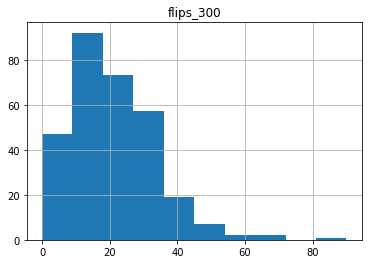

In [50]:
flips_by_doc_300[flips_by_doc_300['query'] == '1133579'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42375e6090>]],
      dtype=object)

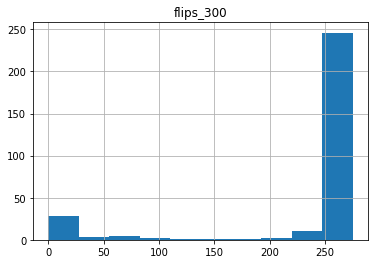

In [51]:
flips_by_doc_300[flips_by_doc_300['query'] == '768208'].hist()

Se observarmos o doc '1008083' para a query '768208', podemos ver que os flips ocorrem porque os scores variam muito.

O modelo parece estar indeciso nesses casos.

In [52]:
flips_by_doc_300[(flips_by_doc_300['query'] ==  '768208') & (flips_by_doc_300['doc'] ==  '1008083')]

,doc,query,flips_300
7498,1008083,768208,252.0


In [53]:
flip_counter_300['768208']['1008083']

{'flip': {'1008087': (9.992648301704321e-06, 0.9999840112104721),
  '1008091': (5.950733793724794e-06, 0.9999705058344261),
  '1029220': (2.8147564989922103e-06, 0.8657618761062622),
  '1053063': (2.958372533612419e-06, 0.999984850220244),
  '1077035': (5.137808784638764e-06, 0.9999677010819141),
  '112760': (1.6879854456419707e-06, 0.9999961901346524),
  '1159091': (1.5709064200564171e-06, 0.9998245787137421),
  '1256489': (2.560916072980035e-06, 0.9999868870063437),
  '1311549': (3.458075752860168e-06, 0.9999663422750018),
  '1338612': (3.2835341698955745e-06, 0.999754552351078),
  '1395758': (2.1376090444391593e-06, 0.9997862484306097),
  '147938': (2.0405186660354957e-06, 0.996668977662921),
  '1505979': (2.6897507723333547e-06, 0.9990031900815666),
  '1594732': (6.6908783082908485e-06, 0.9999893924987191),
  '1693438': (4.5695333028561436e-06, 0.9999661555666535),
  '171087': (1.8062661411022418e-06, 0.9999843287841941),
  '1748026': (5.784968834632309e-06, 0.9870517179369926),
  

### Mudança de ranking

In [54]:
pd.set_option('display.max_rows', 1000)

In [55]:
with open('qrels.dl20-passage.txt', 'r') as f:
  qrels = f.read()

In [56]:
with open('/content/drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec', 'r') as f:
  mono = f.read()

In [57]:
with open('/content/drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.duo.30.trec', 'r') as f:
  duo_30 = f.read()

In [58]:
with open('/content/drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.duo.300.trec', 'r') as f:
  duo_300 = f.read()

In [94]:
df_qrels = pd.DataFrame([row.split() for row in qrels.split('\n')], columns=['query', '_', 'doc', 'rank']).dropna()
mono_df = pd.DataFrame([row.split() for row in mono.split('\n')], columns=['query', '_', 'doc', 'rank', 'score', 'model']).dropna()
duo_30_df = pd.DataFrame([row.split() for row in duo_30.split('\n')], columns=['query', '_', 'doc', 'rank', 'score', 'model']).dropna()
duo_300_df = pd.DataFrame([row.split() for row in duo_300.split('\n')], columns=['query', '_', 'doc', 'rank', 'score', 'model']).dropna()

df_qrels.drop(["_"], axis = 1, inplace = True)
df_qrels.rename({'rank': 'judgement'}, axis=1, inplace = True)
df_qrels["doc_rel"] = np.where(df_qrels["judgement"].astype(int) > 1, 1, 0)

mono_df.drop(["_", "model"], axis = 1, inplace = True)
mono_df.rename({'rank': 'rank_mono', 'score': 'score_mono'}, axis=1, inplace = True)

duo_30_df.drop(["_", "model"], axis = 1, inplace = True)
duo_30_df.rename({'rank': 'rank_30', 'score': 'score_30'}, axis=1, inplace = True)

duo_300_df.drop(["_", "model"], axis = 1, inplace = True)
duo_300_df.rename({'rank': 'rank_300', 'score': 'score_300'}, axis=1, inplace = True)

df_qrels_mono = df_qrels.merge(mono_df, on=['query', 'doc'], how='left')
duo_300_df = duo_300_df.merge(flips_by_doc_300, on=['query', 'doc'], how='left')
duo_30_df = duo_30_df.merge(flips_by_doc_30, on=['query', 'doc'], how='left')

df = duo_300_df.merge(duo_30_df, on=['query', 'doc'], how='left').merge(df_qrels_mono, on=['query', 'doc'], how='outer')
df = df[['query', 'doc', 'rank_mono', 'rank_300', 'flips_300', 'rank_30', 'flips_30', 'judgement', 'doc_rel']].sort_values(by=['query', 'judgement'], ascending=[True, False])

In [61]:
df_qrels['query'].unique()

array(['23849', '42255', '47210', '67316', '118440', '121171', '135802',
       '141630', '156498', '169208', '174463', '258062', '324585',
       '330975', '332593', '336901', '390360', '405163', '555530',
       '583468', '640502', '673670', '701453', '730539', '768208',
       '877809', '911232', '914916', '938400', '940547', '997622',
       '1030303', '1037496', '1043135', '1051399', '1064670', '1071750',
       '1105792', '1106979', '1108651', '1109707', '1110678', '1113256',
       '1115210', '1116380', '1121353', '1122767', '1127540', '1131069',
       '1132532', '1133579', '1136043', '1136047', '1136962'],
      dtype=object)

In [62]:
df[df['query']=='768208'].reset_index(drop = True)

,query,doc,rank_mono,rank_300,flips_300,rank_30,flips_30,judgement
0,768208,52157,1,1,0.0,1,0.0,3
1,768208,52155,3,2,0.0,2,0.0,3
2,768208,813102,7,5,2.0,5,2.0,3
3,768208,8525683,9,7,4.0,7,4.0,3
4,768208,8525681,8,9,4.0,9,4.0,2
5,768208,52161,11,11,2.0,11,2.0,2
6,768208,52160,13,12,2.0,12,2.0,2
7,768208,52158,2,4,1.0,4,1.0,1
8,768208,52159,6,6,3.0,6,3.0,1
9,768208,3515884,10,10,4.0,10,4.0,1


### Hard Queries:

O BM25 não foi capaz de entregar ao próximos estágios do sistema diversas passagens julgadas como relevantes e isso varia de query para query.

In [63]:
collection_tsv = './collection.tsv'
topics = './topics.dl20.txt'

In [64]:
queries = {}
with open(topics) as f:
    for line in f:
        query_id, query_text = line.strip().split('\t')
        queries[query_id] = query_text

In [65]:
collection = {}
with open(collection_tsv) as f:
    for line in f:
        doc_id, doc_text = line.strip().split('\t')
        collection[doc_id] = doc_text

In [66]:
queries['768208']

'what is mamey'

In [67]:
collection['768208']

'Cleveland Browns guard Kevin Zeitler and his dog Amber team up in a talent show against fellow NFL stars. Stream MVP: Most Valuable Performer now on CBS All Access.'

In [68]:
# Conta quantas passagens julgadas como relevantes temos para cada query
df_qrels[df_qrels['judgement'].astype(int) > 0].groupby(['query'])['judgement'].count().reset_index().sort_values(by = "judgement", ascending = False)

,query,judgement
23,118440,217
24,121171,217
42,640502,176
9,1109707,160
40,555530,156
50,914916,132
15,1122767,123
26,141630,118
37,405163,118
41,583468,116


In [69]:
hard_queries = df[df['judgement'].astype(float) > 0].isna().groupby(df['query']).sum()

In [70]:
hard_queries.sort_values(by = 'rank_300', ascending = False)

,query,doc,rank_mono,rank_300,flips_300,rank_30,flips_30,judgement
query,,,,,,,,
118440,0,0,198,200,200,208,208,0
640502,0,0,78,110,110,155,155,0
405163,0,0,22,103,103,118,118,0
555530,0,0,75,99,99,138,138,0
23849,0,0,88,88,88,92,92,0
1109707,0,0,37,71,71,135,135,0
1121353,0,0,19,63,63,85,85,0
121171,0,0,2,56,56,193,193,0
1122767,0,0,32,45,45,100,100,0


### Calculando NDCG por query, dado um num_rerank e função = 'sym_sum_log'

In [122]:
agg.test_aggregate_function(new_aggregate, 'score_dist_prop', **{'mode': 'score_dist_prop'})

In [123]:
agg.test_aggregate_function(aggregate, 'sym_sum_log', **{'mode': 'sym_sum_log'})

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


,qtd_docs,MAP,MRR,P@20,P@30,R@100,R@1000,NDCG@10,NDCG@20,function,J@10,J@20
0,30,0.4309,0.8596,0.4370,0.3444,0.5777,0.5777,0.7309,0.7015,sym_sum_log,0.985185,0.912963
0,50,0.4672,0.8612,0.4324,0.3623,0.6507,0.6507,0.7324,0.6983,sym_sum_log,0.979630,0.912037
0,100,0.4972,0.8613,0.4343,0.3617,0.7513,0.7513,0.7337,0.6992,sym_sum_log,0.979630,0.912963
0,300,0.5110,0.8613,0.4343,0.3611,0.7624,0.8166,0.7338,0.6996,sym_sum_log,0.979630,0.913889


In [124]:
def get_results_by_query(num_rerank, function):
  script_path = download_evaluation_script('trec_eval')
  cmd_prefix = ['java', '-jar', script_path]
  output_pattern_name = f'./pointwise_scores.duo.{num_rerank}.trec'
  args = f'-c -q -l 2 -m ndcg_cut.10,20 -m map -m P.20,30 -m recall.100,1000 -m recip_rank ./qrels.dl20-passage.txt {output_pattern_name}'.split()
  if len(args) > 1:
      cmd = cmd_prefix + args[:]
      if not os.path.exists(cmd[-2]):
          cmd[-2] = get_qrels_file(cmd[-2])
  else:
      cmd = cmd_prefix
  shell = platform.system() == "Windows"
  process = subprocess.Popen(cmd,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE,
                          shell=shell)
  stdout, stderr = process.communicate()
  if stderr:
      print(stderr.decode("utf-8"))
  result = pd.DataFrame([row.split('\t') for row in re.sub(r'.*\s+\t\t', '', stdout.decode("utf-8")).split('\n')[:-1]], columns = ["metric", "query", "value"])
  result.insert(0, "num_rerank", num_rerank)
  result["function"] = function
  metas = ["num_rerank", "query", "function"]
  new_df = result.set_index(['metric'] + metas).unstack('metric').reset_index()
  new_df.columns = ['num_rerank', 'query', 'function', f'P@20_{num_rerank}',	f'P@30_{num_rerank}',	f'map_{num_rerank}',	f'ndcg@10_{num_rerank}',	f'ndcg@20_{num_rerank}',	f'recall@100_{num_rerank}',	f'recall@1000_{num_rerank}',	f'recip_rank_{num_rerank}']
  return new_df[['function', 'query', f'map_{num_rerank}', f'recip_rank_{num_rerank}',  f'P@20_{num_rerank}', 	f'P@30_{num_rerank}', f'recall@100_{num_rerank}', f'recall@1000_{num_rerank}', f'ndcg@10_{num_rerank}',	f'ndcg@20_{num_rerank}']]

In [125]:
ndcg_by_query_30 = get_results_by_query(num_rerank = 30, function = "sym_sum_log")
ndcg_by_query_300 = get_results_by_query(num_rerank = 300, function = "sym_sum_log")

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.


### Correlação entre doculmentos julgados por query e nDCG:

In [126]:
judged_doc_query = df_qrels[["query", "judgement", "doc_rel"]].groupby("query").agg({"judgement":"count", "doc_rel":"sum"})
corr_doc_jud_ndcg_30 = ndcg_by_query_30[["query", "ndcg@10_30", "ndcg@20_30"]].set_index("query").merge(judged_doc_query, on=['query'], how='inner').astype(float)
corr_doc_jud_ndcg_300 = ndcg_by_query_300[["query", "ndcg@10_300", "ndcg@20_300"]].set_index("query").merge(judged_doc_query, on=['query'], how='inner').astype(float)

In [127]:
corr_doc_jud_ndcg_30.corr()

,ndcg@10_30,ndcg@20_30,judgement,doc_rel
ndcg@10_30,1.000000,0.939278,-0.195836,-0.129202
ndcg@20_30,0.939278,1.000000,-0.245095,-0.154442
judgement,-0.195836,-0.245095,1.000000,0.792331
doc_rel,-0.129202,-0.154442,0.792331,1.000000


In [128]:
corr_doc_jud_ndcg_300.corr()

,ndcg@10_300,ndcg@20_300,judgement,doc_rel
ndcg@10_300,1.000000,0.939740,-0.191746,-0.141145
ndcg@20_300,0.939740,1.000000,-0.232420,-0.138074
judgement,-0.191746,-0.232420,1.000000,0.792331
doc_rel,-0.141145,-0.138074,0.792331,1.000000


### Correlação entre quantidade média de flips por docs em uma query e ndcg

Entendi. Talvez gerar um scatter plot onde o eixo x é a quantidade média de flips de uma query, e no eixo y é o nDCG@20 obtido para aquela query? Assim podemos ver a correlação de flips vs ndcg.

#### ndcg@10 e flips em num_rerank = 30

In [129]:
scatter_30 = flips_by_doc_30[["query", "flips_30"]].groupby("query").mean().reset_index().merge(ndcg_by_query_30[["query", "ndcg@10_30"]], on=['query'], how='left')
scatter_30["ndcg@10_30"] = scatter_30["ndcg@10_30"].astype(float)
scatter_30.corr()

,flips_30,ndcg@10_30
flips_30,1.000000,-0.250663
ndcg@10_30,-0.250663,1.000000


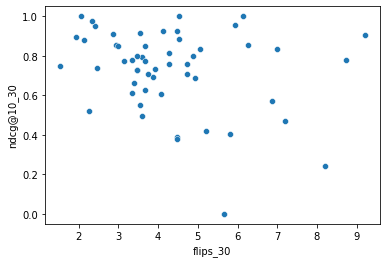

In [130]:
sns.scatterplot(data=scatter_30, x="flips_30", y="ndcg@10_30")
plt.show()

#### ndcg@20 e flips em num_rerank = 30

In [133]:
scatter_30 = flips_by_doc_30[["query", "flips_30"]].groupby("query").mean().reset_index().merge(ndcg_by_query_30[["query", "ndcg@20_30"]], on=['query'], how='left')
scatter_30["ndcg@20_30"] = scatter_30["ndcg@20_30"].astype(float)
scatter_30.corr()

,flips_30,ndcg@20_30
flips_30,1.000000,-0.276535
ndcg@20_30,-0.276535,1.000000


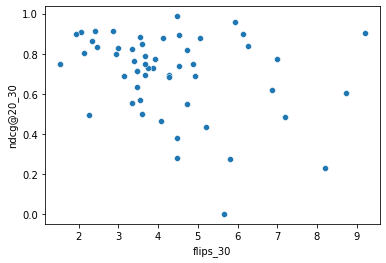

In [135]:
sns.scatterplot(data=scatter_30, x="flips_30", y="ndcg@20_30")
plt.show()

#### ndcg@10 e flips em num_rerank = 300

In [136]:
scatter_300 = flips_by_doc_300[["query", "flips_300"]].groupby("query").mean().reset_index().merge(ndcg_by_query_300[["query", "ndcg@10_300"]], on=['query'], how='left')
scatter_300["ndcg@10_300"] = scatter_300["ndcg@10_300"].astype(float)
scatter_300.corr()

,flips_300,ndcg@10_300
flips_300,1.000000,0.149804
ndcg@10_300,0.149804,1.000000


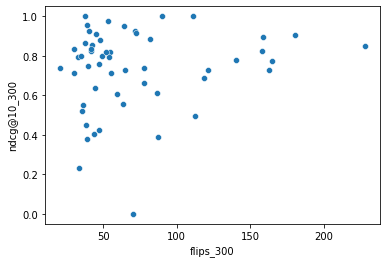

In [137]:
sns.scatterplot(data=scatter_300, x="flips_300", y="ndcg@10_300")
plt.show()

#### ndcg@20 e flips em num_rerank = 300

In [138]:
scatter_300 = flips_by_doc_300[["query", "flips_300"]].groupby("query").mean().reset_index().merge(ndcg_by_query_300[["query", "ndcg@20_300"]], on=['query'], how='left')
scatter_300["ndcg@20_300"] = scatter_300["ndcg@20_300"].astype(float)
scatter_300.corr()

,flips_300,ndcg@20_300
flips_300,1.000000,0.156302
ndcg@20_300,0.156302,1.000000


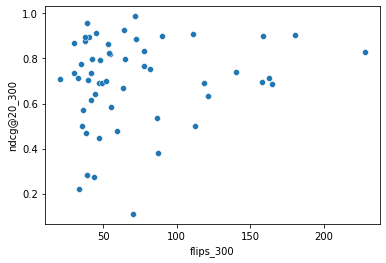

In [139]:
sns.scatterplot(data=scatter_300, x="flips_300", y="ndcg@20_300")
plt.show()

### Correlação entre a distancia media dos scores dos docs em uma query e ndcg


O numero flips pode ficar muito sensivel quando score_1_2 ou score_2_1 ficam proximos de 0.5. Assim, outra versão do eixo x seria o a distancia d = score_1_2 - (1 - score_2_1). Quanto menor for, menor é a "confusão" que o modelo tem quando invertemos os pares de documentos.

In [142]:
def flip_dist_calc(num_rerank):
  f = open(f'./drive/MyDrive/Projeto Final/ia376e_projeto_final/results/output_duot5_pairwise_scores_{num_rerank}.json',)
  pairwise_scores = json.load(f)

  flip_dist = dict()
  for query_id in pairwise_scores.keys():
    flip_dist[query_id] = dict()
    for doc_id in pairwise_scores[query_id].keys():
      if flip_dist[query_id].get(doc_id) is None:
        flip_dist[query_id][doc_id] = dict()
        for vs_doc_id in pairwise_scores[query_id][doc_id]:
          flip_dist[query_id][doc_id][vs_doc_id] = abs(pairwise_scores[query_id][doc_id][vs_doc_id] - (1 - pairwise_scores[query_id][vs_doc_id][doc_id]))

  mean_flip_dist = dict()
  for query_id in flip_dist:
    flip_dist_list = dict()
    for doc_id in flip_dist[query_id]:
      flip_dist_list[doc_id] = np.mean(list(flip_dist[query_id][doc_id].values()))
    
    mean_flip_dist[query_id] = np.mean(list(flip_dist_list.values()))
  return pd.DataFrame.from_dict(mean_flip_dist, orient = 'index', columns = ['mean_score_dist']).rename_axis('query').reset_index()

In [143]:
flip_dist_30 = flip_dist_calc(30)
flip_dist_300 = flip_dist_calc(300)

#### ndcg@10 e  flip_dist em num_rerank = 30

In [152]:
scatter_dist_30 = flip_dist_30.merge(ndcg_by_query_30[["query", "ndcg@10_30"]], on=['query'], how='left')
scatter_dist_30["ndcg@10_30"] = scatter_dist_30["ndcg@10_30"].astype(float)
scatter_dist_30.corr()

,mean_score_dist,ndcg@10_30
mean_score_dist,1.000000,-0.242322
ndcg@10_30,-0.242322,1.000000


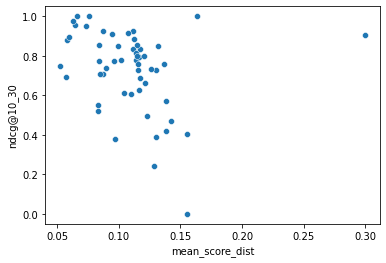

In [153]:
sns.scatterplot(data=scatter_dist_30, x="mean_score_dist", y="ndcg@10_30")
plt.show()

#### ndcg@20 e flip_dist em num_rerank = 30

In [154]:
scatter_dist_30 = flip_dist_30.merge(ndcg_by_query_30[["query", "ndcg@20_30"]], on=['query'], how='left')
scatter_dist_30["ndcg@20_30"] = scatter_dist_30["ndcg@20_30"].astype(float)
scatter_dist_30.corr()

,mean_score_dist,ndcg@20_30
mean_score_dist,1.000000,-0.214344
ndcg@20_30,-0.214344,1.000000


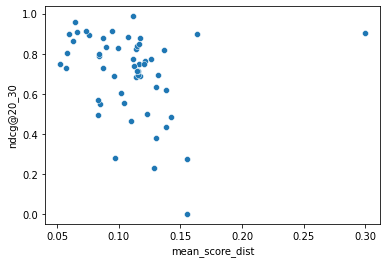

In [155]:
sns.scatterplot(data=scatter_dist_30, x="mean_score_dist", y="ndcg@20_30")
plt.show()

#### ndcg@10 e flip_dist em num_rerank = 300

In [156]:
scatter_dist_300 = flip_dist_300.merge(ndcg_by_query_300[["query", "ndcg@10_300"]], on=['query'], how='left')
scatter_dist_300["ndcg@10_300"] = scatter_dist_300["ndcg@10_300"].astype(float)
scatter_dist_300.corr()

,mean_score_dist,ndcg@10_300
mean_score_dist,1.000000,0.141409
ndcg@10_300,0.141409,1.000000


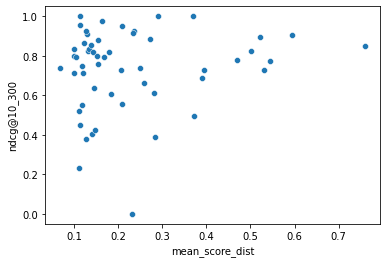

In [157]:
sns.scatterplot(data=scatter_dist_300, x="mean_score_dist", y="ndcg@10_300")
plt.show()

#### ndcg@20 e flip_dist em num_rerank = 300

In [158]:
scatter_dist_300 = flip_dist_300.merge(ndcg_by_query_300[["query", "ndcg@20_300"]], on=['query'], how='left')
scatter_dist_300["ndcg@20_300"] = scatter_dist_300["ndcg@20_300"].astype(float)
scatter_dist_300.corr()

,mean_score_dist,ndcg@20_300
mean_score_dist,1.000000,0.154222
ndcg@20_300,0.154222,1.000000


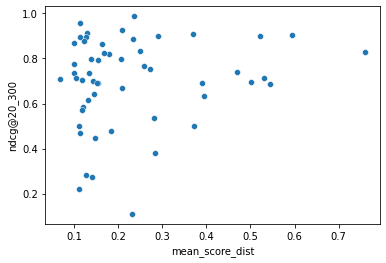

In [159]:
sns.scatterplot(data=scatter_dist_300, x="mean_score_dist", y="ndcg@20_300")
plt.show()

### Outra ideia é medir o número medio de flips por query quando num_docs = 30 e 300. E dai dividir pelo numero total de comparacoes par-a-par. Assim saberemos se há proporcionalmente mais flips com 30 ou com 300 docs.

In [160]:
mean_flip_amount_df.head()

,30,50,100,300
23849,0.200000,0.146939,0.150707,0.145151
42255,0.098851,0.097959,0.180808,0.150346
47210,0.142529,0.106939,0.134949,0.134426
67316,0.140230,0.161633,0.180404,0.198506
118440,0.154023,0.153469,0.192727,0.290725


In [161]:
mean_flip_amount_df.describe()

,30,50,100,300
count,54.000000,54.000000,54.000000,54.000000
mean,0.148191,0.149206,0.172039,0.239459
std,0.058319,0.052905,0.083967,0.153113
min,0.052874,0.073469,0.061414,0.069387
25%,0.115517,0.107755,0.124949,0.133740
50%,0.134483,0.144082,0.156970,0.179621
75%,0.169540,0.179388,0.195758,0.285970
max,0.317241,0.342857,0.470101,0.761472
